# Caso Práctico: Comparación de tres modelos usando 2 características
- Gaussian Naive Bayes
- Regresión Logística
- Árboles de Decisión

Representamos el límite de decisión que generan este tipo de algoritmos mediante el uso de un conjunto de datos más sencillo y con menos características de entrada.

In [98]:
import pandas as pd
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import matplotlib.gridspec as gridspec

In [2]:
def plot_decision_boundary(X, y, clf):
    mins = X.min(axis=0) - 0.5
    maxs = X.max(axis=0) + 0.5

    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 71),
                     np.linspace(mins[1], maxs[1], 81))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    gs = gridspec.GridSpec(1, 2)
    gs.update(hspace=0.8)

    ax = plt.subplot(gs[0])
    ax.contourf(xx, yy, Z, cmap="RdBu", alpha=0.5)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.')
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], 'b.')

    ax = plt.subplot(gs[1])
    ax.contour(xx, yy, Z, [0.5], colors='k')
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.')
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], 'b.')

## Lectura del conjunto de datos y EDA

In [36]:
# Se carga el conjunto de datos
iris = datasets.load_iris()

# Crear un DataFrame a partir de los datos y las etiquetas
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Agregar la columna de la variable objetivo 'target' al DataFrame
df['target'] = iris.target

# Mapear los valores de la variable objetivo a los nombres de las clases
df['class'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,class
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [38]:
# Crear la nueva variable target
df_modelos = df.copy()
df_modelos['target_setosa'] = (df_modelos['class'] == 'setosa').astype(int)

# Eliminar las variables target y class existentes
df_modelos = df_modelos.drop(['target', 'class'], axis=1)

# Mostrar las primeras filas del DataFrame actualizado
df_modelos

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_setosa
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0


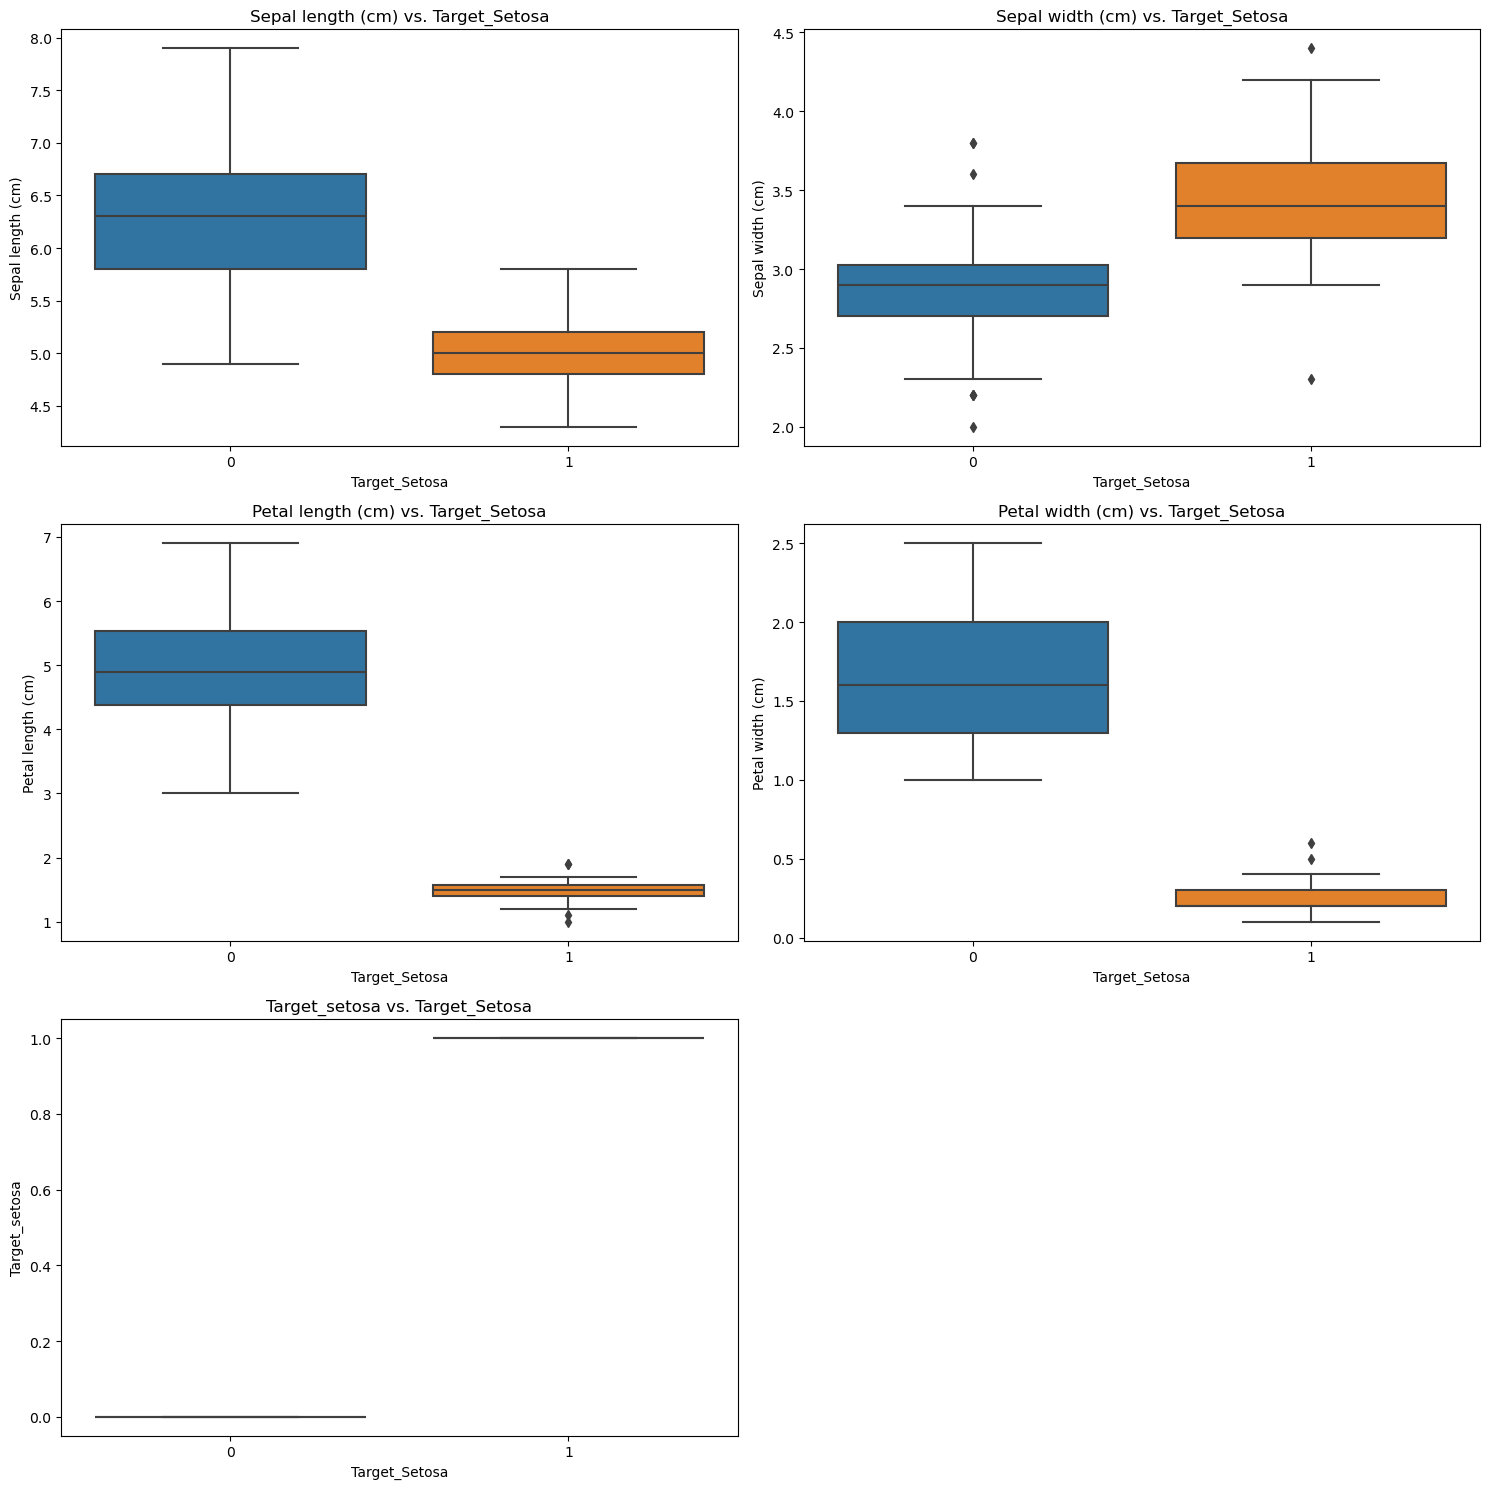

In [44]:
# Calcula el número de columnas para la disposición de subgráficos
num_cols = len(df_modelos.columns)

# Calcula el número de filas necesario para acomodar todos los subgráficos
num_rows = (num_cols + 1) // 2

# Define el tamaño de la figura en función del número de columnas
plt.figure(figsize=(15, 5 * num_rows))

# Genera gráficos de boxplot para todas las variables numéricas
for i, column in enumerate(df_modelos.columns):
    plt.subplot(num_rows, 2, i+1)
    sns.boxplot(x='target_setosa', y=column, data=df_modelos)
    plt.title(f'{column.capitalize()} vs. Target_Setosa')
    plt.xlabel('Target_Setosa')
    plt.ylabel(column.capitalize())

plt.tight_layout()
plt.show()

Observando los gráficos me quedo con las variables sepal length (cm) y sepal width (cm)

In [54]:
# Filtrar el DataFrame por las variables seleccionadas
X = df_modelos[['sepal length (cm)', 'sepal width (cm)']].values
y = df_modelos['target_setosa'].values

## Modelos

### Gaussian Naive Bayes

In [62]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [69]:
# Entrenamos un Gaussian Naive Bayes
model_gaussian = GaussianNB()
model_gaussian.fit(X_train, y_train)

GaussianNB()

In [64]:
# Hacer las predicciones
y_pred_gaussian = model_gaussian.predict(X_test)

In [77]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada
cm_gaussian = confusion_matrix(y_test, y_pred_gaussian)
cm_gaussian

array([[23,  0],
       [ 0, 15]])

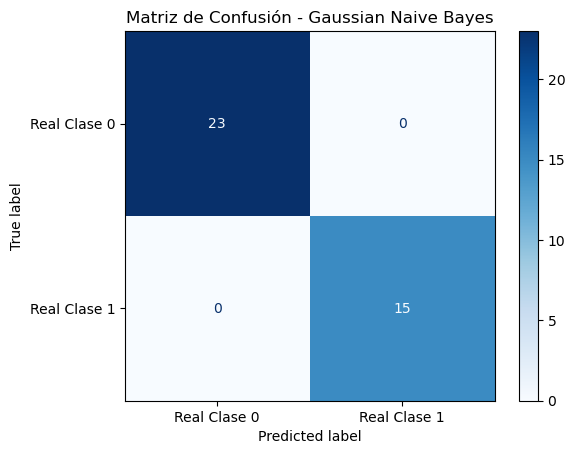

In [99]:
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gaussian, display_labels=["Real Clase 0", "Real Clase 1"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f'Matriz de Confusión - Gaussian Naive Bayes')
plt.show()

- El modelo clasficó correctamente 23 muestras como negativas (clase 0)
- El modelo clasificó correctamente 15 muestras como positivas (clase 1).
- No se clasificaron incorrectamente muestras negativas (clase 0) como positivas.
- No se clasificaron incorrectamente muestras positivas (clase 1) como negativas.

In [81]:
# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred_gaussian)
print("Accuracy:", accuracy)

# Calcular Precision
precision = precision_score(y_test, y_pred_gaussian)
print("Precision:", precision)

# Calcular Recall
recall = recall_score(y_test, y_pred_gaussian)
print("Recall:", recall)

# Calcular F1 Score
f1 = f1_score(y_test, y_pred_gaussian)
print("F1 Score:", f1)

# Calcular Specificity (Tasa de Verdaderos Negativos)
specificity = cm_gaussian[0, 0] / (cm_gaussian[0, 0] + cm_gaussian[0, 1])
print("Specificity:", specificity)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred_gaussian)
print("ROC AUC Score:", roc_auc)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
ROC AUC Score: 1.0


Viendo estas métricas, el modelo Gaussiano usado es perfecto, diferencia a la perfección si es setosa o no

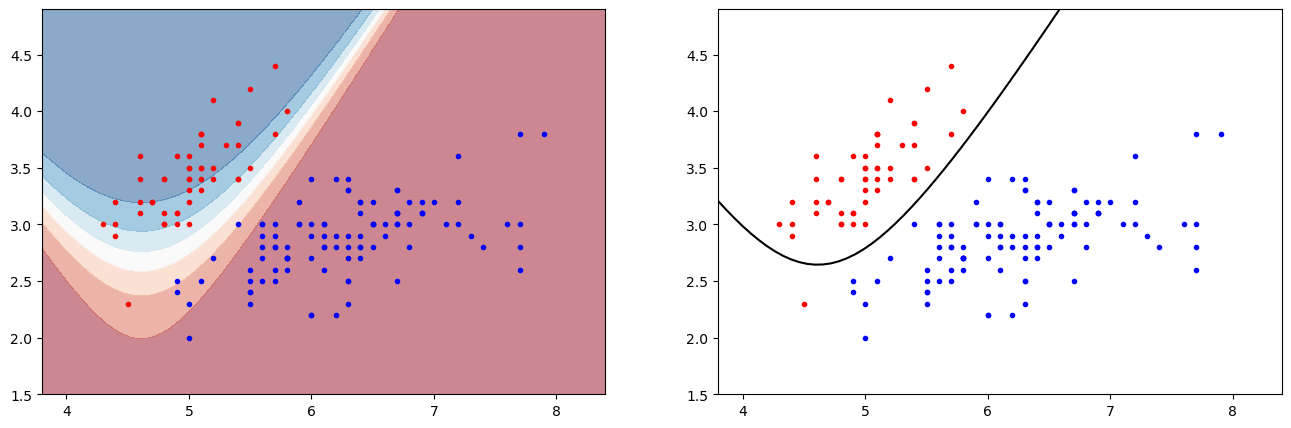

In [68]:
# Límite de decisión de Naive Bayes
plt.figure(figsize=(16, 5))
plot_decision_boundary(X, y, model_gaussian)
plt.show()

### Regresión Logística

In [70]:
# Entrenamos un modelo de Regresión Logística
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

LogisticRegression()

In [71]:
# Realizar predicciones en el conjunto de prueba
y_pred_logistic = model_logistic.predict(X_test)

In [80]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
cm_logistic

array([[23,  0],
       [ 0, 15]])

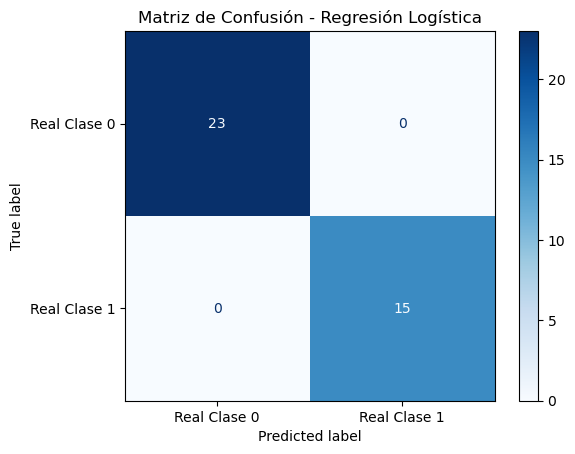

In [100]:
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=["Real Clase 0", "Real Clase 1"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f'Matriz de Confusión - Regresión Logística')
plt.show()

- El modelo clasficó correctamente 23 muestras como negativas (clase 0)
- El modelo clasificó correctamente 15 muestras como positivas (clase 1).
- No se clasificaron incorrectamente muestras negativas (clase 0) como positivas.
- No se clasificaron incorrectamente muestras positivas (clase 1) como negativas.

In [82]:
# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred_logistic)
print("Accuracy:", accuracy)

# Calcular Precision
precision = precision_score(y_test, y_pred_logistic)
print("Precision:", precision)

# Calcular Recall
recall = recall_score(y_test, y_pred_logistic)
print("Recall:", recall)

# Calcular F1 Score
f1 = f1_score(y_test, y_pred_logistic)
print("F1 Score:", f1)

# Calcular Specificity (Tasa de Verdaderos Negativos)
specificity = cm_logistic[0, 0] / (cm_logistic[0, 0] + cm_logistic[0, 1])
print("Specificity:", specificity)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred_gaussian)
print("ROC AUC Score:", roc_auc)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
ROC AUC Score: 1.0


Viendo estas métricas, el modelo de Regresión Logística usado es perfecto, diferencia a la perfección si es setosa o no

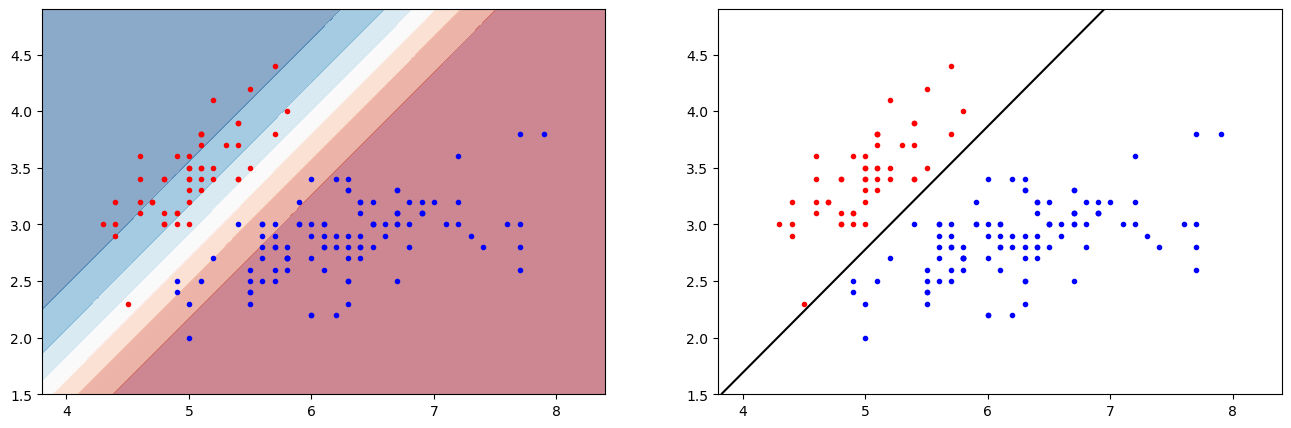

In [83]:
# Límite de decisión Regresión Logística
plt.figure(figsize=(16,5))
plot_decision_boundary(X, y, model_logistic)
plt.show()

### Árboles de decisión

In [84]:
# Crear y entrenar el modelo de Árboles de Decisión
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [85]:
# Hacer predicciones
y_pred_tree = model_tree.predict(X_test)

In [87]:
# Calcular la matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_tree

array([[23,  0],
       [ 2, 13]])

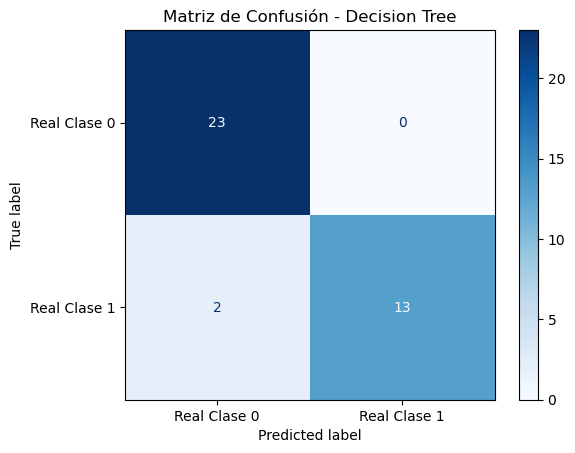

In [101]:
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["Real Clase 0", "Real Clase 1"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f'Matriz de Confusión - Decision Tree')
plt.show()

- El modelo clasficó correctamente 23 muestras como negativas (clase 0)
- El modelo clasificó correctamente 13 muestras como positivas (clase 1).
- Se clasificaron incorrectamente 2 muestras negativas (clase 0) como positivas.
- No se clasificaron incorrectamente muestras positivas (clase 1) como negativas.

In [88]:
# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred_tree)
print("Accuracy:", accuracy)

# Calcular Precision
precision = precision_score(y_test, y_pred_tree)
print("Precision:", precision)

# Calcular Recall
recall = recall_score(y_test, y_pred_tree)
print("Recall:", recall)

# Calcular F1 Score
f1 = f1_score(y_test, y_pred_tree)
print("F1 Score:", f1)

# Calcular Specificity (Tasa de Verdaderos Negativos)
specificity = cm_tree[0, 0] / (cm_tree[0, 0] + cm_tree[0, 1])
print("Specificity:", specificity)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred_tree)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9473684210526315
Precision: 1.0
Recall: 0.8666666666666667
F1 Score: 0.9285714285714286
Specificity: 1.0
ROC AUC Score: 0.9333333333333333


Viendo estas métricas, el modelo es casi perfecto:
- El modelo ha interpretado correctamente el 94,73% de las predicciones
- De las predicciones que el modelo ha interpretado como positivas, ha acertado en el 100% de ellas
- De todos los positivos reales que hay, el modelo ha identificado bien el 86,67% de ellos
- De todos los negativos que hay, el modelo ha identificado bien el 100% de ellos
- El F1 Score es del 92,86%, indicando esto que el modelo nes muy robusto y hay un buen equilibrio entre precisión y sensibilidad
- AUC de 93,33%, indicando esto que es un muy buen modelo

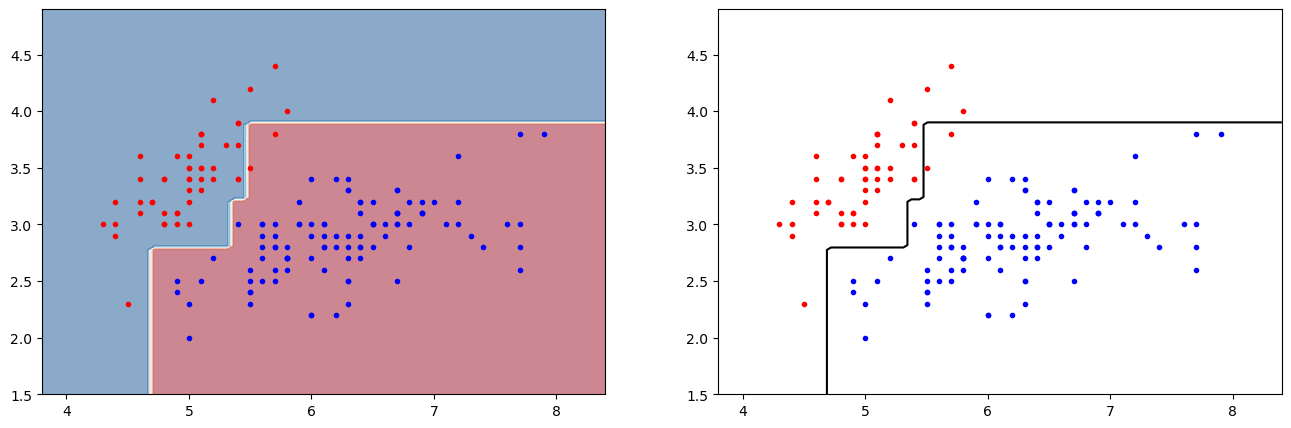

In [89]:
# Límite de decisión Regresión Logística
plt.figure(figsize=(16,5))
plot_decision_boundary(X, y, model_tree)
plt.show()

## Conclusión

Los 3 modelos funcionan perfectamente, pero el Gaussian y la Regresión Logística funcionan mejor.

El modelo Gaussiano Naive Bayes tiende a ser más rápido de entrenar en comparación con la Regresión Logística, con lo cual se optará por este.

# Caso Práctico: Comparación de tres modelos usando 3 características
- Gaussian Naive Bayes
- Regresión Logística
- Árboles de Decisión

## Filtrado por 3 características

In [103]:
# Filtrar el DataFrame por las 3 variables seleccionadas
X = df_modelos[['sepal length (cm)', 'sepal width (cm)', 'petal width (cm)']].values
y = df_modelos['target_setosa'].values

## Modelos

### Gaussian Naive Bayes

In [104]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [106]:
# Entrenamos un Gaussian Naive Bayes
model_gaussian = GaussianNB()
model_gaussian.fit(X_train, y_train)

GaussianNB()

In [107]:
# Hacer las predicciones
y_pred_gaussian = model_gaussian.predict(X_test)

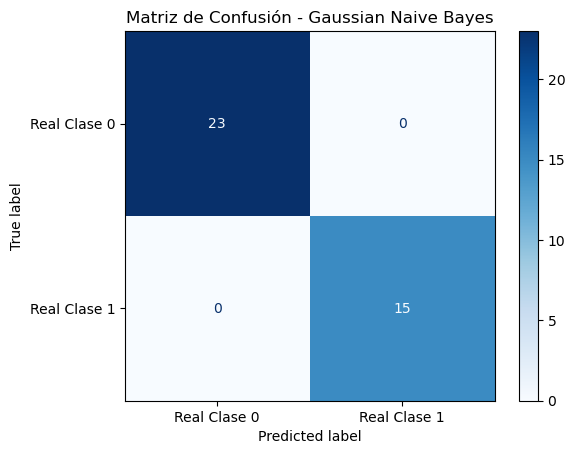

In [108]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada
cm_gaussian = confusion_matrix(y_test, y_pred_gaussian)
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gaussian, display_labels=["Real Clase 0", "Real Clase 1"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f'Matriz de Confusión - Gaussian Naive Bayes')
plt.show()

- El modelo clasficó correctamente 23 muestras como negativas (clase 0)
- El modelo clasificó correctamente 15 muestras como positivas (clase 1).
- No se clasificaron incorrectamente muestras negativas (clase 0) como positivas.
- No se clasificaron incorrectamente muestras positivas (clase 1) como negativas.

In [109]:
# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred_gaussian)
print("Accuracy:", accuracy)

# Calcular Precision
precision = precision_score(y_test, y_pred_gaussian)
print("Precision:", precision)

# Calcular Recall
recall = recall_score(y_test, y_pred_gaussian)
print("Recall:", recall)

# Calcular F1 Score
f1 = f1_score(y_test, y_pred_gaussian)
print("F1 Score:", f1)

# Calcular Specificity (Tasa de Verdaderos Negativos)
specificity = cm_gaussian[0, 0] / (cm_gaussian[0, 0] + cm_gaussian[0, 1])
print("Specificity:", specificity)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred_gaussian)
print("ROC AUC Score:", roc_auc)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
ROC AUC Score: 1.0


Viendo estas métricas, el modelo Gaussiano usado es perfecto, diferencia a la perfección si es setosa o no

### Regresión Logística

In [111]:
# Entrenamos un modelo de Regresión Logística
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

LogisticRegression()

In [112]:
# Realizar predicciones en el conjunto de prueba
y_pred_logistic = model_logistic.predict(X_test)

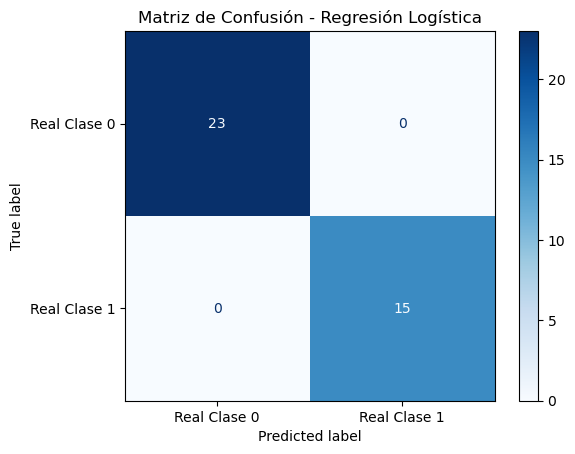

In [114]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=["Real Clase 0", "Real Clase 1"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f'Matriz de Confusión - Regresión Logística')
plt.show()

- El modelo clasficó correctamente 23 muestras como negativas (clase 0)
- El modelo clasificó correctamente 15 muestras como positivas (clase 1).
- No se clasificaron incorrectamente muestras negativas (clase 0) como positivas.
- No se clasificaron incorrectamente muestras positivas (clase 1) como negativas.

In [115]:
# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred_logistic)
print("Accuracy:", accuracy)

# Calcular Precision
precision = precision_score(y_test, y_pred_logistic)
print("Precision:", precision)

# Calcular Recall
recall = recall_score(y_test, y_pred_logistic)
print("Recall:", recall)

# Calcular F1 Score
f1 = f1_score(y_test, y_pred_logistic)
print("F1 Score:", f1)

# Calcular Specificity (Tasa de Verdaderos Negativos)
specificity = cm_logistic[0, 0] / (cm_logistic[0, 0] + cm_logistic[0, 1])
print("Specificity:", specificity)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred_gaussian)
print("ROC AUC Score:", roc_auc)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
ROC AUC Score: 1.0


Viendo estas métricas, el modelo de Regresión Logística usado es perfecto, diferencia a la perfección si es setosa o no

### Árboles de Decisión

In [116]:
# Crear y entrenar el modelo de Árboles de Decisión
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [117]:
# Hacer predicciones
y_pred_tree = model_tree.predict(X_test)

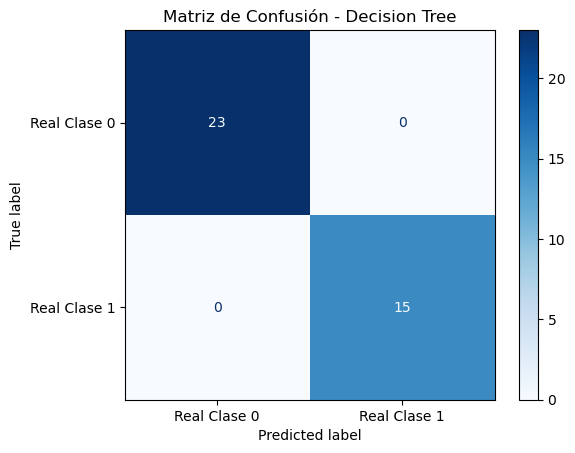

In [118]:
# Calcular la matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree)
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["Real Clase 0", "Real Clase 1"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f'Matriz de Confusión - Decision Tree')
plt.show()

- El modelo clasficó correctamente 23 muestras como negativas (clase 0)
- El modelo clasificó correctamente 15 muestras como positivas (clase 1).
- No se clasificaron incorrectamente muestras negativas (clase 0) como positivas.
- No se clasificaron incorrectamente muestras positivas (clase 1) como negativas.

In [119]:
# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred_tree)
print("Accuracy:", accuracy)

# Calcular Precision
precision = precision_score(y_test, y_pred_tree)
print("Precision:", precision)

# Calcular Recall
recall = recall_score(y_test, y_pred_tree)
print("Recall:", recall)

# Calcular F1 Score
f1 = f1_score(y_test, y_pred_tree)
print("F1 Score:", f1)

# Calcular Specificity (Tasa de Verdaderos Negativos)
specificity = cm_tree[0, 0] / (cm_tree[0, 0] + cm_tree[0, 1])
print("Specificity:", specificity)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred_tree)
print("ROC AUC Score:", roc_auc)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
ROC AUC Score: 1.0


Viendo estas métricas, el modelo de Regresión Logística usado es perfecto, diferencia a la perfección si es setosa o no

## Conclusión

Los 3 modelos funcionan perfectamente.

El modelo Gaussiano Naive Bayes tiende a ser más rápido de entrenar en comparación con la Regresión Logística y el de Árboles de Decisión, con lo cual se optará por este.